In [1]:
# Python 3.9.14
# Run code formatting with `nbqa autopep8 --in-place oslo.ipynb`
# Can run static type checking with `nbqa mypy oslo.ipynb`, but doesn't play nicely with numpy

from collections import Counter
from logbin import logbin
import random
import matplotlib.pyplot as plt  # type: ignore
import numpy as np
from time import sleep
from IPython.display import clear_output  # type: ignore
from scipy.optimize import curve_fit  # type: ignore
import networkx as nx  # type: ignore

In [5]:
class Model:
    def __init__(self, length: int) -> None:
        """
        Initialise a new Oslo model of a given length
        """
        # min length of 3
        if length < 3:
            raise Exception("Min length is 3")
        self.length: int = length
        # the number of grains at a given location
        self.heights: list[int] = [0] * length
        # the gradient at a given location
        self.gradients: list[int] = [0] * length
        # generate an empty thresholds list
        self.thresholds: list[int] = [0] * length
        # record that the system is in the transient state
        self.is_transient: bool = True
        # randomise each of the new threshold values
        for i in range(length):
            self.new_threshold(i)
        # set plotting interactive mode on
        plt.ion()

    def get_length(self) -> int:
        return self.length

    def get_heights(self) -> list[int]:
        return self.heights

    def get_gradients(self) -> list[int]:
        return self.gradients

    def get_thresholds(self) -> list[int]:
        return self.thresholds

    def get_single_threshold(self, int) -> list[int]:
        return self.thresholds[int]

    def get_pile_height(self) -> int:
        return self.heights[0]

    def get_is_transient(self) -> bool:
        return self.is_transient

    def check_index_in_range(self, i: int) -> None:
        """
        Check the index is within the range of the model.
        If not, raise an exception
        """
        # note z_1 has index 0, z_l has index L-1
        if i >= self.length:
            raise Exception("Index out of range")

    def new_threshold(self, i: int) -> None:
        """
        Set a new threshold at position `i`.
        The threshold will be either 1 or 2 with equal chance.
        """
        self.check_index_in_range(i)
        self.thresholds[i] = random.randint(1, 2)

    def drive(self) -> None:
        """
        Add a single grain to the first position
        """
        self.heights[0] += 1
        self.gradients[0] += 1

    def is_supercritical(self, i: int) -> bool:
        """
        Return whether position `i`` is above the threshold
        """
        self.check_index_in_range(i)
        return self.gradients[i] > self.thresholds[i]

    def relax(self, i: int) -> None:
        """
        Relax the  site `i`, assuming it is above the threshold
        """
        self.check_index_in_range(i)
        if i == 0:
            self.heights[i] -= 1
            self.heights[i+1] += 1
            self.gradients[i] -= 2
            self.gradients[i+1] += 1
        elif i == self.length - 1:
            # end relaxation marks the transition to steady state
            if self.is_transient:
                self.is_transient = False
            self.heights[i] -= 1
            self.gradients[i] -= 1
            self.gradients[i-1] += 1
        else:
            self.heights[i] -= 1
            self.heights[i+1] += 1
            self.gradients[i] -= 2
            self.gradients[i-1] += 1
            self.gradients[i+1] += 1

        # ensure no values are below zero
        if self.heights[i] < 0:
            self.heights[i] = 0
        if self.gradients[i] < 0:
            self.gradients[i] = 0

        self.new_threshold(i)

    def cycle(self) -> None:
        """
        Perform one system cycle of driving and relaxation.
        """
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                self.relax(pointer)
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1

    def cycle_with_relax_count(self) -> int:
        """
        Perform one system cycle of driving and relaxation and return the number of relaxations.
        """
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        counter = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                self.relax(pointer)
                counter += 1
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1
        return counter

    def cycle_with_threshold_transition_counts(self) -> dict[int, int]:
        """
        Perform one system cycle and return counts of each threshold transition
        """
        counts = {
            1: {
                1: 0,
                2: 0
            },
            2: {
                1: 0,
                2: 0
            }
        }
        # add a grain to the first position
        self.drive()
        # relax all positions until stable
        pointer = 0
        while pointer < self.length:
            if self.is_supercritical(pointer):
                initial_threshold = self.get_single_threshold(pointer)
                self.relax(pointer)
                final_threshold = self.get_single_threshold(pointer)
                counts[initial_threshold][final_threshold] += 1
                pointer -= 1
                if pointer < 0:
                    pointer = 0
            else:
                pointer += 1
        return counts

    def plot(self, sleep_amount=0, clear_screen=True) -> None:
        """
        Show the current state of the system in a graphic
        """
        sleep(sleep_amount)
        if clear_screen:
            clear_output()
        f = plt.figure()
        f.set_figwidth(3)
        f.set_figheight(6)
        plt.bar(np.array(range(self.length)) + 1, self.heights, width=0.95)
        plt.axis('scaled')
        plt.yticks(range(self.length * 2))
        plt.xticks(np.array(range(self.length)) + 1)
        plt.ylabel("Height")
        plt.xlabel("Site, i")
        plt.grid(axis='y')
        plt.show()

### 1) Testing the Model

#### Testing the logic using plotting

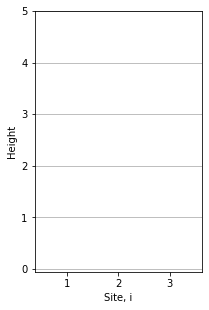

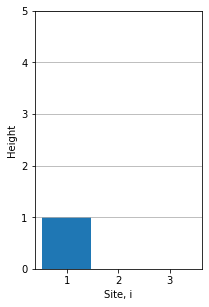

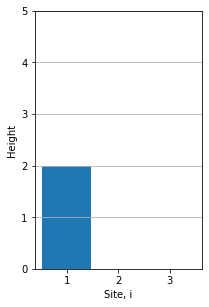

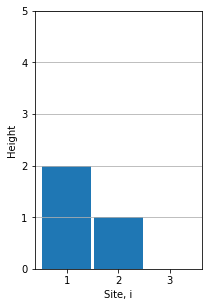

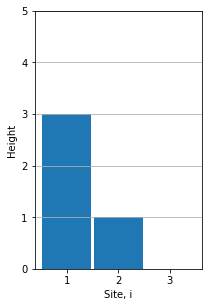

In [6]:
test_model = Model(3)

for i in range(5):
    test_model.plot(clear_screen=False)
    test_model.cycle()

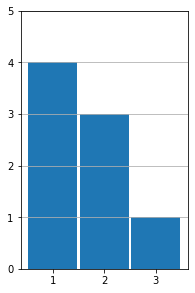

In [4]:
# a quick and easy animation implementation
sleep_amount = 0.5

test_model = Model(3)

for i in range(10):
    test_model.plot(sleep_amount)
    test_model.cycle()

#### Testing the initialised state

In [25]:
model = Model(3)
print("Length:", model.get_length(), "Expected: 3")
print("Heights:", model.get_heights(), "Expected: [0, 0, 0]")
print("Gradients:", model.get_gradients(), "Expected: [0, 0, 0]")
print("Thresholds:", model.get_thresholds(), "Expected: [1|2, 1|2, 1|2]")
print("Pile height:", model.get_pile_height(), "Expected: 0")

Length: 3 Expected: 3
Heights: [0, 0, 0] Expected: [0, 0, 0]
Gradients: [0, 0, 0] Expected: [0, 0, 0]
Thresholds: [1, 1, 1] Expected: [1|2, 1|2, 1|2]
Pile height: 0 Expected: 0


#### Testing the model after one cycle

In [28]:
model = Model(3)
model.cycle()
print("Length:", model.get_length(), "Expected: 3")
print("Heights:", model.get_heights(), "Expected: [1, 0, 0]")
print("Gradients:", model.get_gradients(), "Expected: [1, 0, 0]")
print("Thresholds:", model.get_thresholds(), "Expected: [1|2, 1|2, 1|2]")
print("Pile height:", model.get_pile_height(), "Expected: 1")

Length: 3 Expected: 3
Heights: [1, 0, 0] Expected: [1, 0, 0]
Gradients: [1, 0, 0] Expected: [1, 0, 0]
Thresholds: [2, 1, 1] Expected: [1|2, 1|2, 1|2]
Pile height: 1 Expected: 1


#### Testing the initial distribution of thresholds

This should be 1/2 1 and 1/2 2

In [41]:
size = 1000000
model = Model(size)
thresholds = model.get_thresholds()
ones = sum([i == 1 for i in thresholds])
twos = sum([i == 2 for i in thresholds])
print("System size:", size)
print("Ones:", ones, "Twos:", twos)
print("Fraction of ones:", ones / size)
print("Fraction of twos:", twos / size)

System size: 1000000
Ones: 500117 Twos: 499883
Fraction of ones: 0.500117
Fraction of twos: 0.499883


#### Testing that the transient phase increases with system length

It does, and gives sensible values

In [8]:
# measuring transient phase for L16
test_model = Model(4)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

17


In [9]:
# measuring transient phase for L16
test_model = Model(16)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

229


In [10]:
# measuring transient phase for L32
test_model = Model(32)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

882


#### Testing the average gradient in steady state

This should be between one and two, which it is

In [12]:
model = Model(128)
while model.is_transient:
    model.cycle()
for i in range(10000):
    model.cycle
print(np.average(model.gradients))

1.671875


### Suggested Tests from the Lab Manual

In [42]:
# L16 model should have average height of 26.5

final_heights = []

test_model = Model(16)
# get to steady state
while test_model.get_is_transient():
    test_model.cycle()
# once in steady state run for a set number of trials
for i in range(100000):
    test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print("Expected: 26.5, measured: %.2f" % np.average(final_heights))

Expected: 26.5, measured: 26.53


In [43]:
# L32 model should have average height of 53.9

final_heights = []

test_model = Model(32)
# get to steady state
while test_model.get_is_transient():
    test_model.cycle()
# once in steady state run for a set number of trials
for i in range(10000):
    test_model.cycle()
    final_heights.append(test_model.get_pile_height())

print("Expected: 53.9, measured: %.2f" % np.average(final_heights))

Expected: 53.9, measured: 53.87


### 2a) Height of the Pile

In [44]:
# measuring transient phase for L256, seems to be 50-60k cycles
# since this determines the total number of cycles to run
test_model = Model(256)
counter = 0
while test_model.get_is_transient():
    test_model.cycle()
    counter += 1
print(counter)

56150


In [45]:
heights: list[list[int]] = []
lengths = [4, 8, 16, 32, 64, 128, 256]
number_cycles = 80000

In [46]:
for length in lengths:
    output = []
    model = Model(length)
    for i in range(number_cycles):
        model.cycle()
        output.append(model.get_pile_height())
    heights.append(output)
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


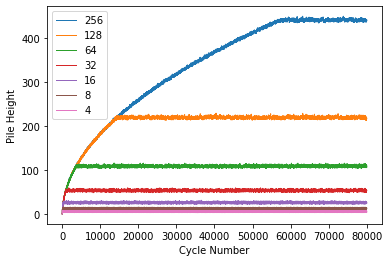

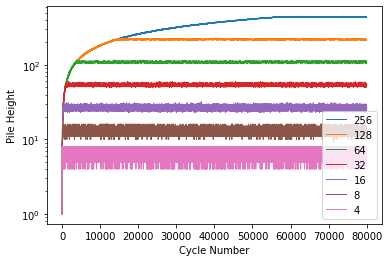

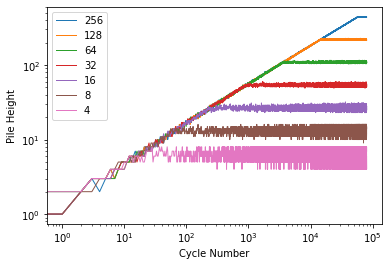

In [48]:
# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.show()

# log linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.yscale("log")
plt.show()

# log log plot
for i in reversed(range(len(lengths))):
    plt.plot(range(number_cycles), heights[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Cycle Number")
plt.ylabel("Pile Height")
plt.xscale("log")
plt.yscale("log")
plt.show()

### 2b) Cross Over Times

In [49]:
cross_over_times = []
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 10  # could increase this later

In [50]:
for length in lengths:
    times = []
    for i in range(repetitions):
        model = Model(length)
        # if a grain exits on the first cycle, counter should be 0
        # since we are measuring total grains *before* an exit
        counter = -1
        while model.get_is_transient():
            model.cycle()
            counter += 1
        times.append(counter)
    cross_over_times.append(np.average(times))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


Fit: 0.85 * x^2


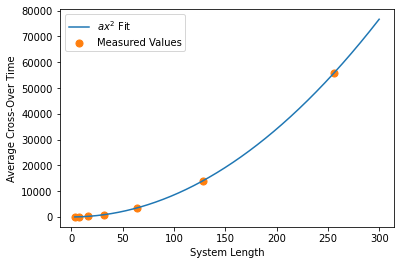

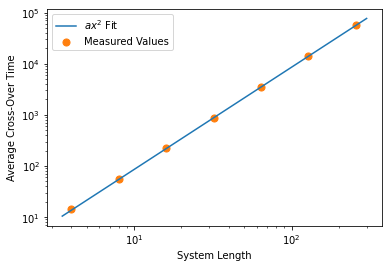

In [64]:
# investigate whether the data scale with L**2
# poly_fit = np.polyfit(lengths, cross_over_times, 2)
# fit_x_vals = np.linspace(0, 300, 100)
# fit_y_vals = np.poly1d(poly_fit)(fit_x_vals)

def squared_func(x, a):
    return a*x**2


popt, pcov = curve_fit(squared_func, lengths, cross_over_times)
fit_x_vals = np.linspace(3.5, 300, 1000)
fit_y_vals = squared_func(fit_x_vals, *popt)
print("Fit: %.2f * x^2" % popt[0])

# linear plot
plt.plot(fit_x_vals, fit_y_vals, label=r"$ax^2$ Fit")
plt.scatter(lengths, cross_over_times, s=50,
            marker="o", c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Cross-Over Time")
plt.show()

# log-log plot
plt.plot(fit_x_vals, fit_y_vals, label=r"$ax^2$ Fit")
plt.scatter(lengths, cross_over_times, s=50,
            marker="o", c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Cross-Over Time")
plt.xscale("log")
plt.yscale("log")
plt.show()

### 2c) Scaling Arguments

# ASK WHETHER TREATING THE SYSTEM AS A TRIANGLE IS THE RIGHT APPROACH

For a system length far larger than 1, there will be some consistent value for the average gradient. This is not necessarily the average of the two possible threshold gradients since a gradient can be changed by grains falling onto it, grains leaving it as well as the critical threshold value.

In [68]:
def get_average_gradient(size):
    steady_state_cycles = 10000
    repetitions = 5
    averages = []
    for i in range(repetitions):
        model = Model(size)
        while model.is_transient:
            model.cycle()
        for i in range(steady_state_cycles):
            model.cycle
        averages.append(np.average(model.gradients))
    print("Size:", size, "Gradients: %.3f", np.average(averages))


get_average_gradient(32)
get_average_gradient(64)
get_average_gradient(128)
get_average_gradient(256)

Size: 32 Gradients: %.3f 1.59375
Size: 64 Gradients: %.3f 1.646875
Size: 128 Gradients: %.3f 1.6734375
Size: 256 Gradients: %.3f 1.7109375


Empirically the average value is found to be about 1.65, however all that matters is that this average gradient is scale independent on large scales. Given a set gradient, this gives large systems beyond the cross over point a triangular form, with angles that do not change with scale for all sufficiently large numbers. 

This gives the height of the triangle to be directly proportional to the base of the triangle, i.e. the length of the system. Similarly, cross over time corresponds to the area of the triangle, and thus cross over time should scale with square of the system length.

#### Side Investigation Into Average Gradient

The reason the average gradient is not 1.5 is because sites with threshold 1 are more likely to topple than those with threshold 2. This means there is a probability of sites of threshold 1 toppling and having a threshold of 1 again, a probability they'll go from 1 to 2, 2 to 2 and 2 to 1. This can then be represented with a two state Markov graph.

In [20]:
# cycle_with_threshold_transition_counts

counts: dict[int, dict[int, int]] = Counter({
    1: Counter({
        1: 0,
        2: 0
    }),
    2: Counter({
        1: 0,
        2: 0
    })
})
model_size = 64
repetitions = 1
cycles = 100000

for i in range(repetitions):
    model = Model(model_size)
    while model.is_transient:
        model.cycle()
    for i in range(cycles):
        new_counts = model.cycle_with_threshold_transition_counts()
        for i in counts.keys():
            counts[i].update(new_counts[i])

print(counts)

Counter({1: Counter({2: 1598551, 1: 1596720}), 2: Counter({1: 1598547, 2: 1598455})})


In [21]:
total_transitions = 0
for i in counts.keys():
    for j in counts[i].keys():
        total_transitions += counts[i][j]
print("Total transitions mesaured:", total_transitions)

for i in counts.keys():
    for j in counts[i].keys():
        print("%d to %d: %.6f" % (i, j, counts[i][j] / total_transitions))

Total transitions mesaured: 6392273
1 to 1: 0.249789
1 to 2: 0.250076
2 to 1: 0.250075
2 to 2: 0.250061


These effects are actually smaller than I would have thought, but are probably still big enough to calculate the average gradient. Might return to this at the end for fun.

Also although they seem to be robust, 1 -> 1 and 1 -> 2 should be identical, and both lower than 2 -> 1 and 2 -> 2 which is puzzling.

It would be interesting to do a similar state transition analysis for the gradient itself, rather than for the threshold, since gradient is more clearly deviating from a symmetrical 1.5 value. 

### Average gradient with system size

After realising my theoretical argument is based on an average gradient that doesn't vary with system size, I tried to test it only to find it does indeed increase with system size! Not sure why this is happening, whether there's a bias in my sampling of average gradient or whether there's something more interesting going on.

### 2d) Data Collapse of Average Height Scaling

In [22]:
def average_different_lengths(a: list[list[int]]) -> list[int]:
    """
    A function to average lists of different lengths.
    All lists are truncated to the shortest length.
    """
    list_lengths = [len(i) for i in a]
    min_length = min(list_lengths)
    for l in a:
        while len(l) > min_length:
            l.pop(-1)
    return list(np.average(a, axis=0))

In [23]:
average_heights_with_time: list[list[int]] = []
# lengths = [4, 8, 16, 32, 64, 128, 256]
lengths = [16, 32, 64, 128, 256]
repetitions = 5  # could increase this later
steady_state_cycles = 1000

In [24]:
for length in lengths:
    height_lists: list[list[int]] = []
    for i in range(repetitions):
        model = Model(length)
        height_values: list[int] = []
        while model.get_is_transient():
            model.cycle()
            height_values.append(model.get_pile_height())
        for i in range(steady_state_cycles):
            model.cycle()
            height_values.append(model.get_pile_height())
        height_lists.append(height_values)
    average_heights_with_time.append(average_different_lengths(height_lists))
    print(length, 'complete')

16 complete
32 complete
64 complete
128 complete
256 complete


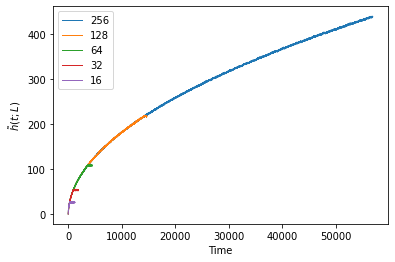

In [25]:
# poly_fit = np.polyfit(lengths, average_heights, 1)
# fit_x_vals = np.linspace(0, 300, 100)
# fit_y_vals = np.poly1d(poly_fit)(fit_x_vals)
# plt.plot(fit_x_vals, fit_y_vals, label='1st Order Polynomial Fit')

for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_heights_with_time[i])), average_heights_with_time[i], label=str(
        lengths[i]), linewidth=1)
plt.legend()
plt.xlabel("Time")
plt.ylabel(r"$\tilde{h}(t;L)$")
plt.show()

The form of the data collapse has to be:

$\text{F: } \tilde{h}(t;L) = x_1 \text{F}(x_2)$

Considering we have a theoretical argument that steady state height scales with system length $L$, we hypothesise that $x_1 = L$

Which should lead to all the peaks reaching the same maximum height when we plot:

$\frac{\tilde{h}(t;L)}{L} = \text{F}(x_2)$

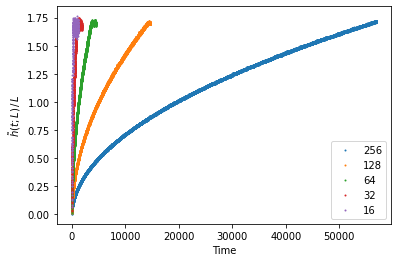

In [26]:
y_vals = [np.array(i) for i in average_heights_with_time]
x_vals = [list(range(len(i))) for i in average_heights_with_time]

# divide each of the y_vals by their system length
for i in range(len(y_vals)):
    y_vals[i] = y_vals[i] / lengths[i]

for i in reversed(range(len(lengths))):
    plt.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1)
plt.legend()
plt.xlabel("Time")
plt.ylabel(r"$\tilde{h}(t;L) \, / \, L$")
plt.show()

This looks correct, meaning $x_1 = L$ as predicted.

Horizontally, the data still hasn't collapsed though, meaning that there is another scaling in the argument of F. This can be seen to be the crossover time, which we have argued should be proportional to the square of the system length. Thus we predict that $x_2 = t/L^2$. Plotting $t/L^2$ on the x axis rather than $t$ should therefore lead to the desired data collapse:

$\frac{\tilde{h}(t;L)}{L} = \text{F}(\frac{t}{L^2})$

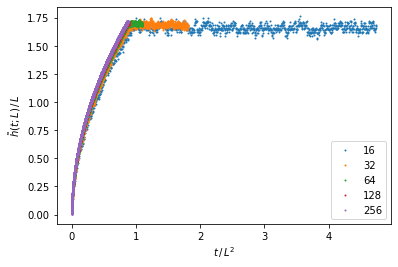

In [27]:
y_vals = [np.array(i) for i in average_heights_with_time]
x_vals = [np.array(range(len(average_heights_with_time[i])))/(lengths[i]**2)
          for i in range(len(average_heights_with_time))]

# divide each of the y_vals by their system length
for i in range(len(y_vals)):
    y_vals[i] = y_vals[i] / lengths[i]

for i in range(len(lengths)):
    plt.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1)
plt.legend()
plt.xlabel(r"$t \, / \, L^2$")
plt.ylabel(r"$\tilde{h}(t;L) \, / \, L$")
plt.show()

Which does indeed seem to give us a data collapse! 

Since this is a graph of the scaling function, we can see that for $x>>1$ it becomes constant, and for $x<<1$ it tends to 0. 

### Behaviour during the transient

Given that our theoretical predictions of treating the system as a large triangle seem to have been validated, this would lead us to conclude that pile height during the transient phase is proportional to the square root of the area, which itself is given by the time:

$\tilde{h}(t;L) \propto{} t^{1/2}$

We can verify this simply:

In [32]:
average_height_sequences = []
lengths = [4, 8, 16, 32, 64, 128, 256]
repetitions = 5

In [33]:
for length in lengths:
    heights = []
    for i in range(repetitions):
        model = Model(length)
        values = []
        while model.get_is_transient():
            model.cycle()
            values.append(model.get_pile_height())
        heights.append(values)
    average_height_sequences.append(average_different_lengths(heights))
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


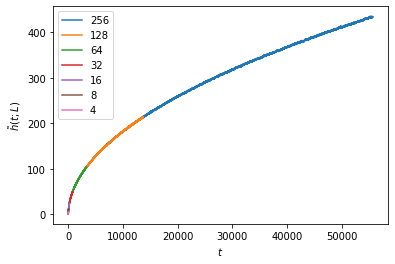

In [34]:
# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$\tilde{h}(t;L)$")
plt.show()

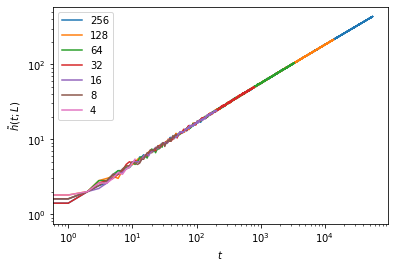

In [35]:
# log-log plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$\tilde{h}(t;L)$")
plt.show()

Fit found to be: y = 1.837 t^0.5


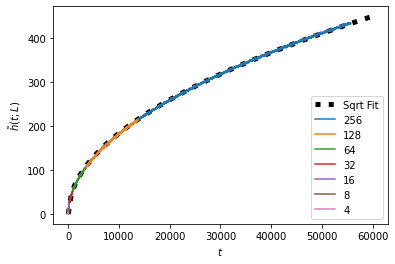

In [36]:
# fit the sqrt function to the data
def sqrt_func(x, a0):
    return a0 * np.sqrt(x)


popt, pcov = curve_fit(sqrt_func, range(
    len(average_height_sequences[-1])), average_height_sequences[-1])
print("Fit found to be: y = %.3f t^0.5" % popt[0])
fit_x_vals = np.linspace(0, 60000, 100)
fit_y_vals = sqrt_func(fit_x_vals, popt)
plt.plot(fit_x_vals, fit_y_vals, label='Sqrt Fit',
         linestyle='dotted', c='k', linewidth=5)

# linear plot
for i in reversed(range(len(lengths))):
    plt.plot(range(len(average_height_sequences[i])),
             average_height_sequences[i], label=str(lengths[i]))
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$\tilde{h}(t;L)$")
plt.show()

Given we are now confident that:

$\tilde{h}(t;L) = k t^{1/2}$,

where $k$ is some constant, holds, we know that during the transient:

$\tilde{h}(t;L) = k t^{1/2}  = L\text{F}(\frac{t}{L^2})$

and so, during the transient:

$\mathcal{F}(\frac{t}{L^2}) = \frac{k}{L}t^{1/2} = k(\frac{t}{L^2})^{1/2}$

We can plot the scaling function for only the transient period and then curve fit to see whether this holds:

In [37]:
average_heights_with_time: list[list[int]] = []
# lengths = [4, 8, 16, 32, 64, 128, 256]
lengths = [16, 32, 64, 128, 256]
repetitions = 5  # could increase this later

In [38]:
for length in lengths:
    height_lists: list[list[int]] = []
    for i in range(repetitions):
        model = Model(length)
        height_values: list[int] = []
        while model.get_is_transient():
            model.cycle()
            height_values.append(model.get_pile_height())
        height_lists.append(height_values)
    average_heights_with_time.append(average_different_lengths(height_lists))
    print(length, 'complete')

16 complete
32 complete
64 complete
128 complete
256 complete


Fit found to be: y = 1.837 t^0.5


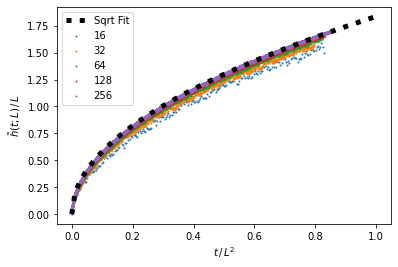

In [41]:
# fitting the 256 data
popt, pcov = curve_fit(sqrt_func, range(
    len(average_height_sequences[-1])), average_height_sequences[-1])
print("Fit found to be: y = %.3f t^0.5" % popt[0])
fit_x_vals = np.linspace(0, 1, 100)
fit_y_vals = sqrt_func(fit_x_vals, popt)
plt.plot(fit_x_vals, fit_y_vals, label='Sqrt Fit',
         linestyle='dotted', c='k', linewidth=5)

y_vals = [np.array(i) for i in average_heights_with_time]
x_vals = [np.array(range(len(average_heights_with_time[i])))/(lengths[i]**2)
          for i in range(len(average_heights_with_time))]

# divide each of the y_vals by their system length
for i in range(len(y_vals)):
    y_vals[i] = y_vals[i] / lengths[i]

for i in range(len(lengths)):
    plt.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1)
plt.legend()
plt.xlabel(r"$t \, / \, L^2$")
plt.ylabel(r"$\tilde{h}(t;L) \, / \, L$")
plt.show()

This also confirms our prediction that both would share the same value for $k$ which is found to be 1.837 for both fits. 

### Extension: Steady State and the Full Function

To complete our equations for the scaling function, we consider the behaviour in the steady state. 

If we considered an alternative setup where the average gradient was exactly 1, then we would expect the grain pile to form a triangle with height equal to it's base length. The area of this triangle would be $t$, since 1 grain is added to the pile per time interval. This would give the area of the triangle to be: 
$$t = \frac{1}{2}\tilde{h}(t;L)^2$$

therefore:
$$\begin{align}
\tilde{h}(t;L) &= \sqrt{2t} \\
&= \sqrt{2} t^{1/2}
\end{align}$$

If we now introduce an average gradient of $g$, then we find:
$$\begin{align}
t &= \frac{1}{2} \, \frac{\tilde{h}(t;L)^2}{g} \\
\tilde{h}(t;L) &= \sqrt{2gt} \\
&= \sqrt{2g} \, t^{1/2}
\end{align}$$

Meaning that:
$$\begin{align}
k &= \sqrt{2g} \\
g &= \frac{1}{2}k^2
\end{align}$$

In [45]:
0.5 * 1.837**2

1.6872844999999999

Which does roughly match our explicit calculation from earlier, which found the average gradient to be $\approx 1.65$

Given this, we can now predict the steady state height to be simply the average gradient multiplied by the length of the system:
$$\begin{align}
\tilde{h}(t;L) &= gL = \frac{1}{2} k^2 L \\
\frac{\tilde{h}(t;L)}{L} &= g = \frac{1}{2} k^2 \\
\end{align}$$

But when does the data collapsed scaling function transition from the transient to steady state? 

One method would be simply to find the value of the transient function when it reaches our predicted steady state value, but we can instead reason what it should be from 

This will be when the base of the triangle reaches the system size. Since we have established $g$ as the average gradient, we know that the crossover time $t_c$ is given by:
$$t_{c} = \frac{1}{2} \cdot \text{width} \cdot \tilde{h} = \frac{1}{2} g L^2$$

as the scaling function is plotted against $t/L^2$:
$$\frac{t_c}{L^2} = \frac{g}{2} = \frac{k^2}{4}$$

This means we can now formulate the entire piecewise scaling function, which we predict to be of the form:
$$\mathcal{F}(t/L^2) = 
\left\{
    \begin{align}
        &k (t/L^2)^{1/2} &\text{for } t/L^2 < \frac{k^2}{4} \nonumber \\
        &\frac{1}{2}k^2  &\text{for } t/L^2 > \frac{k^2}{4} \nonumber
    \end{align}
\right\}
$$

which we can simplify by substituting $u = t/L^2$ and the average gradient $g = \frac{1}{2}k^2$:
$$\mathcal{F}(u) = 
\left\{
    \begin{align}
        &(2gu)^{1/2} &\text{for } u < \frac{g}{2} \nonumber \\
        &g  &\text{for } u > \frac{g}{2} \nonumber \\
    \end{align}
\right\}
$$

This means the scaling function now has one variable parameter which we can fit to the data, in order to see if this proposed form is correct:

In [57]:
average_heights_with_time: list[list[int]] = []
# lengths = [4, 8, 16, 32, 64, 128, 256]
lengths = [16, 32, 64, 128, 256]
repetitions = 5  # could increase this later
steady_state_cycles = 1000

In [58]:
for length in lengths:
    height_lists: list[list[int]] = []
    for i in range(repetitions):
        model = Model(length)
        height_values: list[int] = []
        while model.get_is_transient():
            model.cycle()
            height_values.append(model.get_pile_height())
        for i in range(steady_state_cycles):
            model.cycle()
            height_values.append(model.get_pile_height())
        height_lists.append(height_values)
    average_heights_with_time.append(average_different_lengths(height_lists))
    print(length, 'complete')

16 complete
32 complete
64 complete
128 complete
256 complete


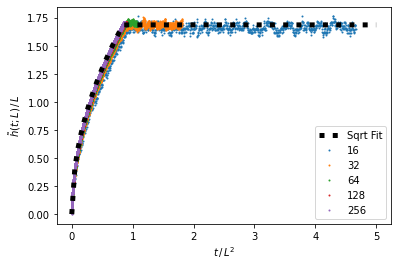

In [78]:
# fit the proposed scaling function
def scaling_func(x, g):
    try:
        x[0]
        results = []
        for x_i in x:
            if x_i < 0.5*g:
                results.append((2*g*x_i) ** 0.5)
            else:
                results.append(g)
        return results
    except:
        if x < 0.5*g:
            return (2*g*x_i) ** 0.5
        else:
            return g


y_vals = [np.array(i) for i in average_heights_with_time]
x_vals = [np.array(range(len(average_heights_with_time[i])))/(lengths[i]**2)
          for i in range(len(average_heights_with_time))]

# plotting using the previously found k value
k = 1.837
g = 0.5*k**2
fit_x_vals = np.linspace(0, 5, 100)
fit_y_vals = scaling_func(fit_x_vals, g)
plt.plot(fit_x_vals, fit_y_vals, label='Sqrt Fit',
         linestyle='dotted', c='k', linewidth=5)

# divide each of the y_vals by their system length
for i in range(len(y_vals)):
    y_vals[i] = y_vals[i] / lengths[i]

for i in range(len(lengths)):
    plt.scatter(x_vals[i], y_vals[i], label=str(
        lengths[i]), s=1)
plt.legend()
plt.xlabel(r"$t \, / \, L^2$")
plt.ylabel(r"$\tilde{h}(t;L) \, / \, L$")
plt.show()

### 2e) Scaling Corrections to Height

Note here we should not take averages over repeated runs of the model for each length

In [4]:
height_sequence_list: list[list[int]] = []
lengths = [4, 8, 16, 32, 64, 128, 256]
num_cycles = 100000

In [5]:
for length in lengths:
    height_sequence: list[int] = []
    model = Model(length)
    while model.get_is_transient():
        model.cycle()
    for i in range(num_cycles):
        model.cycle()
        height_sequence.append(model.get_pile_height())
    height_sequence_list.append(height_sequence)
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


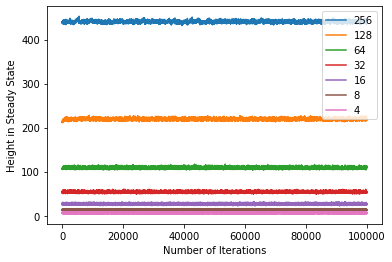

In [6]:
# linear plot of the raw data
for i in reversed(range(len(lengths))):
    plt.plot(range(len(height_sequence_list[i])),
             height_sequence_list[i], label=str(lengths[i]))
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Height in Steady State")
plt.show()

In [7]:
# counting frequencies to check the histograms
counts: dict[int, int] = {}
for i in np.sort(height_sequence_list[0]):
    try:
        counts[i] += 1
    except:
        counts[i] = 1
counts

{4: 416, 5: 13844, 6: 45549, 7: 33868, 8: 6323}

Length: 4
Average: 6.31838
Std: 0.803
Probability distribution:


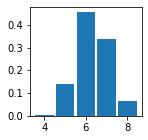

Length: 8
Average: 12.97109
Std: 0.959
Probability distribution:


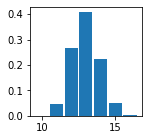

Length: 16
Average: 26.54319
Std: 1.139
Probability distribution:


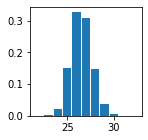

Length: 32
Average: 53.90565
Std: 1.359
Probability distribution:


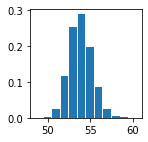

Length: 64
Average: 108.9266
Std: 1.589
Probability distribution:


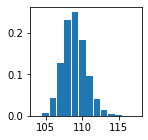

Length: 128
Average: 219.23579
Std: 1.836
Probability distribution:


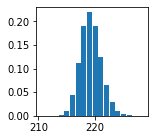

Length: 256
Average: 440.45963
Std: 2.196
Probability distribution:


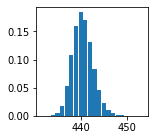

In [8]:
for i in range(len(lengths)):
    data = height_sequence_list[i]
    print("="*10)
    print("Length:", lengths[i])
    average = np.average(data)
    print("Average:", average)
    std = np.std(data)
    print("Std:", "%.3f" % std)
    print("Probability distribution:")
    plt.subplots(figsize=(2, 2))
    plt.hist(data, max(data) - min(data) + 1, density=True,
             rwidth=0.9, range=(min(data)-0.5, max(data)+0.5))
    plt.show()

### Corrections to Scaling

Plotting the average heights against system size, we find:

In [9]:
# calculate the averages
average_height_list: list = []
for l in height_sequence_list:
    average_height_list.append(np.average(l))
print(average_height_list)

[6.31838, 12.97109, 26.54319, 53.90565, 108.9266, 219.23579, 440.45963]


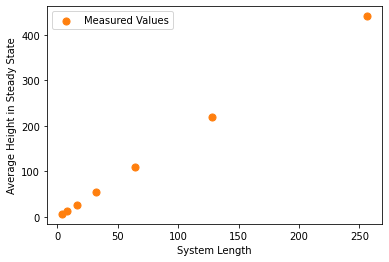

In [10]:
plt.scatter(lengths, average_height_list, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("System Length")
plt.ylabel("Average Height in Steady State")
plt.show()

Which looks as expected, with the dominant scaling following $a_0 L$. 

We can remove the leading order behaviour by plotting the average height divided by $L$, in order to reveal the corrections to scaling.

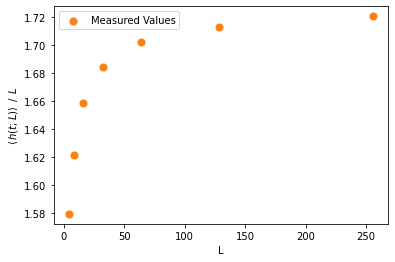

In [11]:
scaled_values = [average_height_list[i] / lengths[i]
                 for i in range(len(lengths))]

plt.scatter(lengths, scaled_values, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("L")
plt.ylabel(r"$\langle \, h (t;L) \rangle \,\,\, / \,\,\, L$")
plt.show()


Assuming the corrections to scaling are of the form given in the instructions:

$\langle h (t;L) \rangle_t = a_0 L (1 - a_1 L^{- \omega_1})$

since we are ignoring higher order terms, we can remove the leading order behaviour to leave:

$\frac{\langle h (t;L) \rangle_t}{L} = a_0 (1 - a_1L^{-\omega_1})$

If we fit a first order polynomial to the data, we should get a value for a_0:

Fit: a0 = 1.75, a1 = 0.18, o1 = 0.47


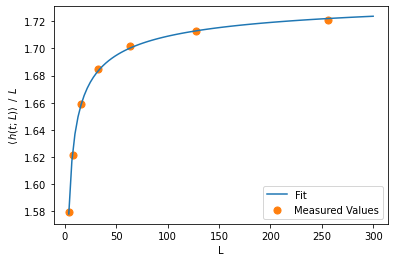

In [12]:
# fitting just a0 L, neglecting further terms
def corrections_to_scaling_func(L, a0, a1, o1):
    return a0 * (1 - a1 * L ** (-o1))


popt, pcov = curve_fit(corrections_to_scaling_func, lengths, scaled_values)
x_vals = np.linspace(4, 300, 100)
plt.plot(x_vals, corrections_to_scaling_func(x_vals, *popt),
         label="Fit", color="C0")
print("Fit: a0 = %.2f, a1 = %.2f, o1 = %.2f" % (popt[0], popt[1], popt[2]))

plt.scatter(lengths, scaled_values, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel("L")
plt.ylabel(r"$\langle \, h (t;L) \rangle \,\,\, / \,\,\, L$")
plt.show()

As a visual confirmation, this fit looks very good as well $\omega_1$ being $>0$ as required.

### 2f) Standard Deviation Scaling 

How does standard deviation scale with system length - we can plot our values for standard deviation against 

In [13]:
std_values = [np.std(data) for data in height_sequence_list]

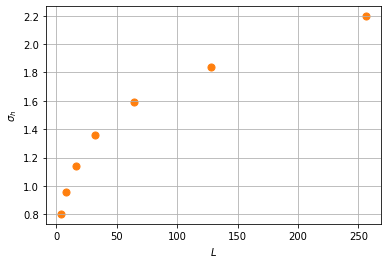

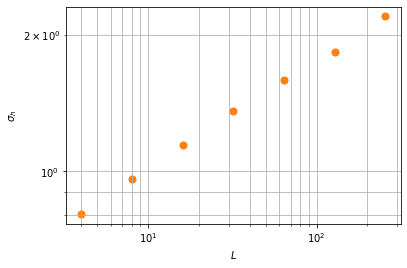

In [14]:
# linear plot
plt.scatter(lengths, std_values, s=50, marker="o",
            c="C1")
plt.xlabel(r"$L$")
plt.ylabel(r"$\sigma_h$")
plt.grid()
plt.show()

# log-log plot
plt.scatter(lengths, std_values, s=50, marker="o",
            c="C1")
plt.xlabel(r"$L$")
plt.ylabel(r"$\sigma_h$")
plt.yscale("log")
plt.xscale("log")
plt.grid(which='both')
plt.show()

From the logarithmic plot, the std values seem to follow a power law

Fit: a0 = 0.59, o1 = 0.24


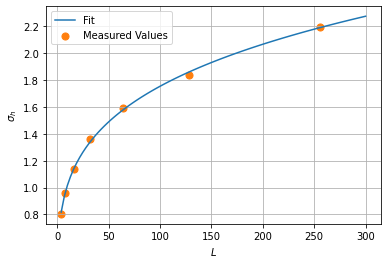

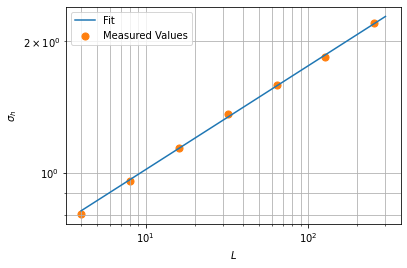

In [15]:
# of the various random functions, this seems to work best
def std_cts_func(L, a0, o1):
    return a0 * L ** o1


popt, pcov = curve_fit(std_cts_func, lengths, std_values)
x_vals = np.linspace(4, 300, 100)
print("Fit: a0 = %.2f, o1 = %.2f" % (popt[0], popt[1]))

# linear plot
plt.plot(x_vals, std_cts_func(x_vals, *popt),
         label="Fit", color="C0")
plt.scatter(lengths, std_values, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel(r"$L$")
plt.ylabel(r"$\sigma_h$")
plt.grid()
plt.show()

# log-log plot
plt.plot(x_vals, std_cts_func(x_vals, *popt),
         label="Fit", color="C0")
plt.scatter(lengths, std_values, s=50, marker="o",
            c="C1", label="Measured Values")
plt.legend()
plt.xlabel(r"$L$")
plt.ylabel(r"$\sigma_h$")
plt.yscale("log")
plt.xscale("log")
plt.grid(which='both')
plt.show()

Found this fit to be: $\sigma = a_0 \, L^{-\omega_1}$

Where $a_0 = 0.56$, $\omega_1 = 0.26$

Unsure about this, at it seems like a weird form but nothing else seemed to fit the data well. Perhaps I'm missing something obvious.

Checked with Kim and this is correct, with the point being that you have an increasing precision in the measurement of the average gradient, as system size increases.

#### Predictions for average slope and its standard deviation in the limit of $L \to \infty$:

Average slope scales linearly in the limit of $L \to \infty$, however its standard deviation is unbounded since it also scales with a power law of $L$ and thus also tends to $\infty$ as $L \to \infty$, however the std will not grow as fast as the average gradient, since std only scales with $L^{0.26}$ wheras average slope scales with $L^1$

Therefore $\sigma_h / \langle h \rangle \to 0$ as $L \to \infty$

### 2g) The Height Probability Distribution

i) if each individual gradient was independent of every other gradient then by the central limit theorem, we would expect the height probability distribution to be a symmetrical Gaussian about the average. In this scenario the std would follow the standard error formula, and thus would decrease with the square root of the number of sites.

ii) plotting all of the height probability distributions individually:

Length: 4
Average: 6.31838
Std: 0.803
Probability distribution:


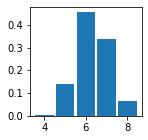

Length: 8
Average: 12.97109
Std: 0.959
Probability distribution:


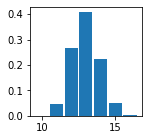

Length: 16
Average: 26.54319
Std: 1.139
Probability distribution:


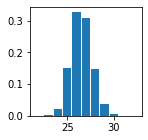

Length: 32
Average: 53.90565
Std: 1.359
Probability distribution:


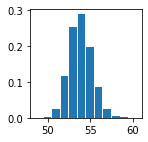

Length: 64
Average: 108.9266
Std: 1.589
Probability distribution:


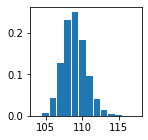

Length: 128
Average: 219.23579
Std: 1.836
Probability distribution:


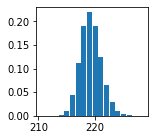

Length: 256
Average: 440.45963
Std: 2.196
Probability distribution:


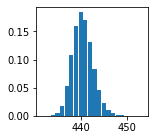

In [16]:
for i in range(len(lengths)):
    data = height_sequence_list[i]
    print("="*10)
    print("Length:", lengths[i])
    average = np.average(data)
    print("Average:", average)
    std = np.std(data)
    print("Std:", "%.3f" % std)
    print("Probability distribution:")
    plt.subplots(figsize=(2, 2))
    plt.hist(data, max(data) - min(data) + 1, density=True,
             rwidth=0.9, range=(min(data)-0.5, max(data)+0.5))
    plt.show()

Correct approach is to use the formula for a Gaussian and then do a data collapse in the same way that we did so before.

Formula for a Gaussian is:
$$P(h;L) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\Bigg({-\frac{1}{2} \Big(\frac{h-\langle h \rangle}{\sigma}} \Big)^2 \Bigg)$$

We can do a similar approach to the finite scaling ansatz and collapse this by plotting:

$$\sigma_h P(h;L) = \mathcal{G}\bigg(\frac{h - \langle h \rangle}{\sigma_h}\bigg) = \frac{1}{\sqrt{2 \pi}} \exp(-\frac{1}{2}x^2)$$

Therefore, plotting $\sigma_h P(h;L)$ against $\frac{h - \langle h \rangle}{\sigma_h}$ should lead to a data collapse where all Gaussian functions will collapse to a single Gaussian with mean 0 and std 1. 

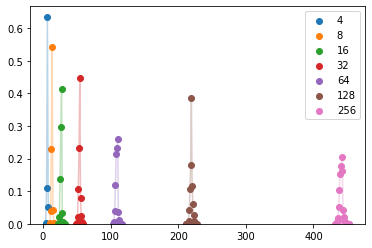

In [18]:
# first plotting all of the data on one graph
for i in range(len(lengths)):
    data = height_sequence_list[i]
    n, bins, patches = plt.hist(data, max(data) - min(data), density=True, range=(
        min(data)-0.5, max(data)+0.5), alpha=0)
    bin_means = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
    max_height = max(n)
    plt.scatter(bin_means, n, color="C%s" % i, label=lengths[i])
    plt.plot(bin_means, n, color="C%s" % i, alpha=0.3)
plt.legend()
plt.show()

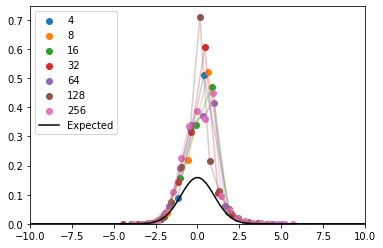

In [23]:
def collapse_func(x):
    return (1 / (2*np.pi) * np.exp(-0.5*x**2))


for i in range(len(lengths)):
    data = height_sequence_list[i]
    average = np.average(data)
    std = np.std(data)

    n, bins, patches = plt.hist(data, max(data) - min(data), density=True, range=(
        min(data)-0.5, max(data)+0.5), alpha=0)
    bin_means = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]

    scaled_n = np.array(n)*std
    scaled_bin_means = [(bin_mean - average)/std for bin_mean in bin_means]
    plt.scatter(scaled_bin_means, scaled_n, color="C%s" % i, label=lengths[i])
    plt.plot(scaled_bin_means, scaled_n, color="C%s" % i, alpha=0.3)

# plot the expected function for comparison


def collapse_func(x):
    return (1 / (2*np.pi) * np.exp(-0.5*x**2))


x_vals = np.linspace(-10, 10, 100)
plt.plot(x_vals, collapse_func(x_vals), color='k', label='Expected')

plt.legend()
plt.xlim(-10, 10)
plt.show()

Although the data has indeed collapsed, it has not collapsed onto the expected function, plotted in black. Therefore this is strong evidence that the gradients are not independent. 

# ASK ABOUT THIS

iii) For the numerical test as to whether the gradients are indeed statistically independent, is finding the average gradient sufficient? If they were independent, we would expect this value to be 1.5, however it was found to be over 1.6, indicating that they are not independent?

In [24]:
averages = []

for i in range(100):
    model = Model(64)
    while model.is_transient:
        model.cycle()
    for i in range(10000):
        model.cycle
    averages.append(np.average(model.gradients))

print(np.average(averages))

1.64734375


### 3) Avalanches

Plotting the time series of avalanche size

(later should average these over multiple repetitions)

In [15]:
avalanches_list: list[list[int]] = []
lengths = [4, 8, 16, 32, 64, 128, 256]
num_cycles = 100000

In [16]:
for length in lengths:
    model = Model(length)
    avalanches: list[int] = []
    # get the model to steady state
    while model.get_is_transient():
        model.cycle()
    # only then count the avalanches
    for i in range(num_cycles):
        avalanches.append(model.cycle_with_relax_count())
    avalanches_list.append(avalanches)
    print(length, 'complete')

4 complete
8 complete
16 complete
32 complete
64 complete
128 complete
256 complete


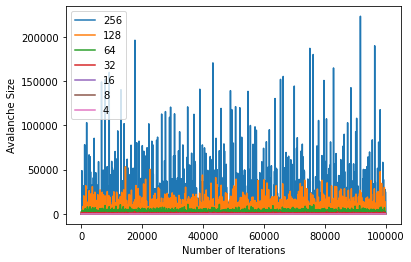

In [22]:
# linear plot of the raw data
for i in reversed(range(len(lengths))):
    plt.plot(range(len(avalanches_list[i])),
             avalanches_list[i], label=str(lengths[i]))
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Avalanche Size")
plt.show()

In [23]:
# checking that the "avalanche size 0" cycles are being recorded
counts = {}
for i in np.sort(avalanches_list[0]):
    try:
        counts[i] += 1
    except:
        counts[i] = 1
print(counts)
print("Number of avalanches size 0:", counts[0])

{0: 35716, 1: 17234, 2: 6610, 3: 3602, 4: 5570, 5: 2820, 6: 2914, 7: 3026, 8: 4106, 9: 2028, 10: 2062, 11: 3186, 12: 1232, 13: 2034, 14: 1499, 15: 1616, 16: 583, 17: 1230, 18: 839, 19: 269, 20: 557, 21: 499, 22: 234, 23: 95, 24: 209, 25: 121, 26: 30, 27: 34, 28: 17, 29: 14, 30: 8, 31: 5, 34: 1}
Number of avalanches size 0: 35716


In [24]:
# calculate the probabilities
probs_list = []

for l in range(len(lengths)):
    probs = {}
    for i in np.sort(avalanches_list[l]):
        try:
            probs[i] += 1/num_cycles
        except:
            probs[i] = 1/num_cycles
    probs_list.append(probs)

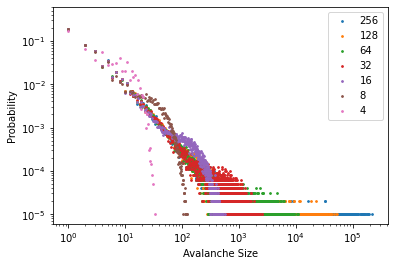

In [25]:
# plotting the probability values
for l in reversed(range(len(lengths))):
    plt.scatter(probs_list[l].keys(),
                probs_list[l].values(), s=3, label=str(lengths[l]))
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Avalanche Size')
plt.ylabel('Probability')
plt.show()

i) Using the log binning function we can now plot them all on the same graph:

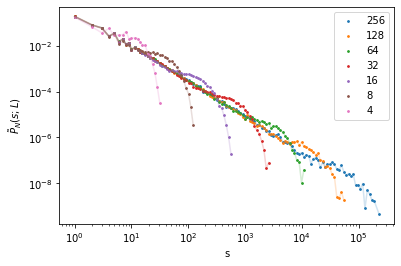

In [26]:
# note I went for a scale of 1.1, since that looked the best and is also used in the lecture notes in the data collapse section
log_binned_avalanches_x = []
log_binned_avalanches_y = []
scale = 1.1
for i in avalanches_list:
    x_vals, y_vals = logbin(i, scale=scale, zeros=False)
    log_binned_avalanches_x.append(x_vals)
    log_binned_avalanches_y.append(y_vals)

for i in reversed(range(len(lengths))):
    plt.scatter(
        log_binned_avalanches_x[i], log_binned_avalanches_y[i], s=3, label=str(lengths[i]))
    plt.plot(log_binned_avalanches_x[i], log_binned_avalanches_y[i], alpha=0.2)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('s')
plt.ylabel(r'$\tilde{P}_N(s;L)$')
plt.show()

Describing qualitatively the results, we can see very similar results to what was expected. We see a scale invariant distribution of avalanche size probability throughout the scaling region, followed by a system size dependent cut-off. Avalanches are found across many orders of magnitude, and smaller avalanches are more likely than larger ones.

ii) Applying the finite-size scaling ansatz:

This is given as:
$$\begin{align}\tilde{P}_N(s;L) &\propto s^{-\tau_s} \mathcal{G}(s / L^D) &\text{for } L \gg 1, s \gg 1 \nonumber\end{align}$$

Rearranging to align the peaks, we can plot:
$$s^{\tau_s} \tilde{P}(s;L) \propto \mathcal{G} (s / L^D)$$

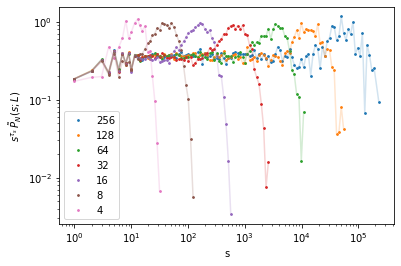

In [156]:
# multiplying each of the the y values by s^tau
tau_s = 1.55
scaled_avalanches_y = []
for i in range(len(log_binned_avalanches_y)):
    scaled_avalanche = []
    for j in range(len(log_binned_avalanches_y[i])):
        scaled_avalanche.append(
            log_binned_avalanches_y[i][j] * log_binned_avalanches_x[i][j]**(tau_s))
    scaled_avalanches_y.append(scaled_avalanche)

for i in reversed(range(len(lengths))):
    plt.scatter(
        log_binned_avalanches_x[i], scaled_avalanches_y[i], s=3, label=str(lengths[i]))
    plt.plot(log_binned_avalanches_x[i], scaled_avalanches_y[i], alpha=0.2)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('s')
plt.ylabel(r'$s^{\tau_s} \, \tilde{P}_N(s;L)$')
plt.show()

The peaks of the "bumps" seem to line up for $\tau_s \sim 1.55$. We can now perform the data collapse by plotting $s/L^D$ on the x axis and optimising $D$:

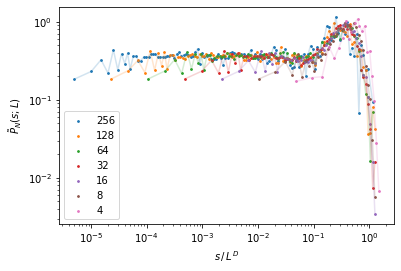

In [55]:
# dividing each of the the x values by L^D
D = 2.2
scaled_avalanches_x = []
for i in range(len(log_binned_avalanches_x)):
    scaled_avalanches_x.append(log_binned_avalanches_x[i] / (lengths[i]**D))

for i in reversed(range(len(lengths))):
    plt.scatter(
        scaled_avalanches_x[i], scaled_avalanches_y[i], s=3, label=str(lengths[i]))
    plt.plot(scaled_avalanches_x[i], scaled_avalanches_y[i], alpha=0.2)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$s \, / \, L^D$')
plt.ylabel(r'$\tilde{P}_N(s;L)$')
plt.show()

The data does indeed collapse, with an avalanche dimension $D \sim 2.2$ which is expected since the notes give a value of 2.25

It may be possible to get a much better data collapse with repetitions and more data points, at which point it may be possible to get to 2.25

### 3b) Avalanche Moments

In [61]:
def calculate_moment(data, order):
    scaled_data = [i**order for i in data]
    return sum(scaled_data) / len(data)

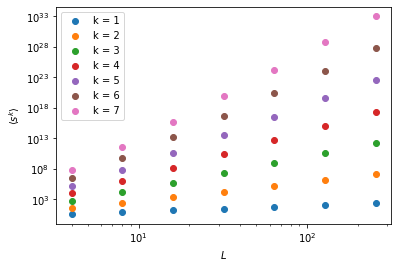

In [73]:
moments = [1, 2, 3, 4, 5, 6, 7]

# plotting
for m in moments:
    y_vals = []
    for l in range(len(lengths)):
        y_vals.append(calculate_moment(avalanches_list[l], m))
    plt.scatter(lengths, y_vals, c="C%s" % (m-1), label="k = %s" % m)

plt.xlabel("$L$")
plt.ylabel(r"$\langle s^k \rangle$")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

From the derivation in the lectures, we know that we can find $D$ and $\tau_s$ from the scaling relation of the moments:
$$\begin{align}
\langle s^k \rangle &\propto L^{D(1 + k - \tau_s)} \\
\therefore \log \langle s^k \rangle &= D(1 + k - \tau_s) \log L + \log (\text{constant})
\end{align}$$

Therefore, if we fit the scaling behaviours of the moments, we can can then plot them against $k$:

/var/folders/4c/jqcncstx7v9ccg0y_h0sbdy00000gn/T/ipykernel_12066/730580679.py:19: RuntimeWarning: overflow encountered in double_scalars
  results.append(a0 * L_i ** a1)


[array([0.99725903, 1.00002674]), array([0.32423718, 3.18753778]), array([0.14792344, 5.41333202]), array([0.08552289, 7.6385557 ]), array([0.06664835, 9.83496756]), array([ 0.06963067, 11.99444428]), array([ 0.09300819, 14.12046239]), array([ 0.14988225, 16.22052456]), array([ 0.27626743, 18.3023903 ]), array([ 0.55770598, 20.37263131])]


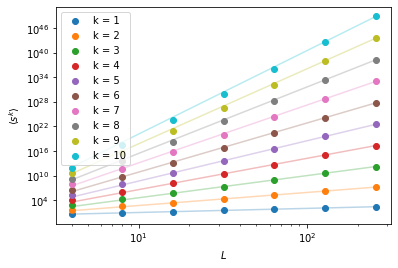

In [131]:
moments = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# calculate the moments
moments_values = []
for m in moments:
    y_vals = []
    for l in range(len(lengths)):
        y_vals.append(calculate_moment(avalanches_list[l], m))
    moments_values.append(y_vals)

# fit power laws to each of the moments


def power_law_func(L, a0, a1):
    try:
        L[0]
        results = []
        for L_i in L:
            results.append(a0 * L_i ** a1)
        return results
    except:
        return a0 * L ** a1


fit_data = []
initial_guesses = [[1, 1], [1, 2], [1, 3], [1, 7], [
    1, 10], [1, 12], [1, 14], [1, 18], [1, 20], [1, 22]]
for m in range(len(moments)):
    popt, pcov = curve_fit(power_law_func, lengths,
                           moments_values[m], p0=initial_guesses[m])
    fit_data.append(popt)
print(fit_data)

# plotting
for m in range(len(moments)):
    plt.scatter(lengths, moments_values[m], c="C%s" % (
        m), label="k = %s" % (moments[m]))
    plt.plot(lengths, power_law_func(
        lengths, *fit_data[m]), color="C%s" % (m), alpha=0.3)
plt.xlabel("$L$")
plt.ylabel(r"$\langle s^k \rangle$")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

Now we have the data from the fits, we can plot it against moment number:

Fit: -1.05 + 2.16 * k


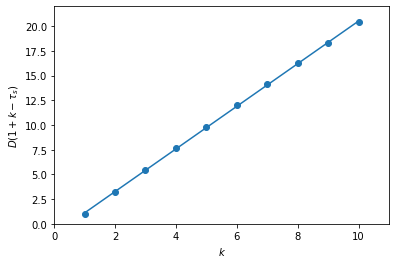

In [152]:
# extract the value
y_vals = [i[1] for i in fit_data]
x_vals = moments

# fit a straight line to the data


def linear_func(k, a, b):
    try:
        k[0]
        results = []
        for k_i in k:
            results.append(a + b*k_i)
        return results
    except:
        return a + b*k


popt, pcov = curve_fit(linear_func, x_vals, y_vals)
print("Fit: %.2f + %.2f * k" % (popt[0], popt[1]))

# plotting
plt.scatter(x_vals, y_vals)
plt.plot(x_vals, linear_func(x_vals, popt[0], popt[1]))
plt.xlabel("$k$")
plt.xlim(0, 11)
plt.ylim(0, 22)
plt.ylabel(r"$D(1 + k - \tau_s)$")
plt.show()

This gives $D = 2.16$ which is very similar to what we got before, and from the y intercept (y_0) we can find $\tau_s$ from:
$$y_0 = D (1 - \tau_s)$$
$$\therefore \tau_s = 1 - \frac{y0}{D}  = 1 + \frac{1.05}{2.16} = 1.48$$

Which is very close to our previous value of 1.55